# Omission decoding from human LFP in superior temporal gyrus


## Purpose of this notebook

This notebook accompanies the paper uploaded on Biorxiv, which is currently in revision for publication. The decoding analyses described in the paper can be found below. 

Once the data has been preprocessed and verified to your satisfaction, this is the notebook where the decoding analyses are run. The actual work of the decoding is once again specified in the `omission` module, specifically in `omission.build_classifier()`. For the purposes of the paper these analyses here are done on high-frequency band (70-150Hz) analytic amplitudes, but this notebook can be used with data involving different preprocessing steps as well. 

In this notebook there are a number of different decoding approaches: 
- Verification of heard-syllable decoding (sanity check): Can we decode hear 'Ba' from 'Ga sounds? 

- First pass omission decoding: feature selection based on above analysis (good heard-syllable decoding electrodes), followed by decoding of omitted Ba vs Ga

- Alternative decoding approach: Can we train the classifier on heard Ba/Ga, and use that to decode which syllable was omitted? (this is testing the strong hypothesis on template activation)

- Post-hoc analysis: Decoding of omitted syllable based on above-baseline omission activations

## Notebook setup and file loading

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2|

In [3]:
import os, glob, sys
import numpy as np
import pandas as pd
import mne
import omission
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import stats

from matplotlib.backends.backend_pdf import PdfPages

In [4]:
## Setup specifics per subject
foldername = {'AB62':'Albany62', 'AB71': 'Albany71', 'AB78':'Albany78', 'AB79': 'Albany79', 'AB81': 'Albany81'}
PicName = {}
elecNum = {251, 231}


In [5]:
# Select which subject you want to look at: 
subject_ID = 'AB62'
# 0- AB62, 1-AB71, 2-AB78, 3-AB79, 4-AB81'

In [6]:
foldername[subject_ID]

'Albany62'

## Load the data

In [7]:
epochs_fns = sorted(glob.glob('/home/knight/ECOGprediction/OmissionDetection/Data/' + foldername[subject_ID]+ '/sge/epochDataHilbertHG_Dig-B*'))
print epochs_fns

['/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B03.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B04.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B05.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B06.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B07.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B08.npz']


In [8]:
ep_arrs = []
drop_chans = []
for f in epochs_fns:
    ep = np.load(f)
    globals().update(ep) # load all vars, changed 'locals' to 'globals' to fix error that came up when I turned this into a function
    print data.shape, info.item(), events.shape, tmin, event_id
    eparr = mne.EpochsArray(data, info.item(), events, tmin.item(), event_id.item(), baseline=None)
    #ep_arrs.append(eparr)
    if 'tmp' in locals():
        a = set(tmp).symmetric_difference( eparr.info['ch_names'])
        print 'following channel does not exist in all blocks'
        print a
        drop_chans.append(list(a))

    tmp = eparr.info['ch_names']


    ep_arrs.append(eparr)

#remove channels that are not in all blocks
print drop_chans
import itertools
flat_drop = list(itertools.chain.from_iterable(drop_chans))
good_chs = [ch for ch in ep_arrs[0].info['ch_names'] if ch not in
        flat_drop]


print('hello')

for i in range(len(ep_arrs)):
    ep_arrs[i].pick_channels(good_chs) #


event_ids = event_id.item()
all_epochs = mne.epochs.concatenate_epochs(ep_arrs)
print event_ids
del ep_arrs
del tmp

# If control block
#ep_arrs_control = []
#ep = np.load(epochs_fns_ctrl)
#locals().update(ep)
#print data.shape, info.item(), events.shape, t_min, event_id
#control_epochs = mne.EpochsArray(data, info.item(), events, t_min.item(), event_id.item(), baseline = None)

#event_idsControl = event_id.item()

(470, 229, 301) <Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 11, ...
    chs : list | 229 items (MISC: 229)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 70.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 25.0 Hz
    meas_date : numpy.ndarray | 1969-12-31 16:00:00
    nchan : int | 229
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
   

## Define options that will be used throughout the notebook for classification

In [9]:
n_cv = 10 # cross-validation iterations
n_ch = len(all_epochs.ch_names)
chan_scores = np.zeros(shape=(n_ch, n_cv)) # output structure for cv

In [10]:
t0 = 0 # seconds before (negative) or after stim to start classifying from
t1 = .5 # s after stim to stop using data to classify
percentiles = [.5, 2.5, 5, 50, 95, 97.5, 99.5]

In [11]:
# finds relevant percentiles from bootstrap distr, based on values given in 'percentiles'
def pcts(scores, percentiles):
    for p in percentiles:
        print '%.1f%%: %.04f'%(p, np.percentile(scores, p))

In [12]:
from sklearn import svm
logit = svm.LinearSVC(penalty= 'l2')
model = logit # model is the var that we pass to functions

## Code to setup plotting of data on de 2D brain

In [13]:
# Update accordingl
from os import path as op
from scipy.ndimage import imread

sub_name = 'AB62'
im_path = '/home/knight/ECOGprediction/Scripts/Python/Old/AB62gray.png'
print im_path
# We've already clicked and exported
layout_path = '/home/knight/ECOGprediction/Scripts/Python/Old'
layout_name = 'custom_layoutAB62.lout'

/home/knight/ECOGprediction/Scripts/Python/Old/AB62gray.png


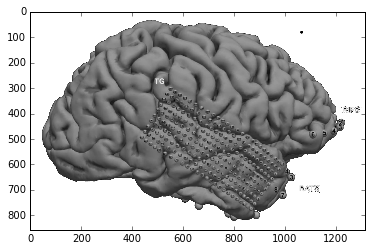

In [14]:
# Show the picture to check if it's the right one
im = imread(im_path)
plt.imshow(im)

In [15]:
# We've already got the layout, load it
lt = mne.channels.read_layout(layout_name, path=layout_path, scale=False)

In [29]:
from ecogtools.viz import plot_activity_on_brain
x = lt.pos[:,0] * im.shape[1]
y = im.shape[0]-(lt.pos[:,1] * im.shape[0])

## First analysis: Verification of heard syllable decoding performance -- sanity check

In [17]:
# Classify heard 'Ba' from heard 'Ga' based on all present channels -- this could take a while.. 

# classify using cross-validation, 
# fit the model to all the data (so it's trained and returned)
# optionally also run 500 bootstrap iterations (shuffled labels) to get null dist
# bgmodel, scores_exp_baga, scores_shuff_baga = omission.build_classifier(all_epochs, event_ids,
bg_model, scores_bg, scores_shuff_bg = omission.build_classifier(all_epochs, event_ids,
            [], ['ba', 'ga'], model, n_cv=n_cv,
                    t_start=t0, t_stop=t1, shuffle=True, n_shuff_it=500, rescale = False)

/usr/local/anaconda-2.4.0/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Channel index(es):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217]

KeyboardInterrupt: 

In [ ]:
# Plot results
np.percentile(scores_shuff_bg, 5)
print np.mean(scores_bg), scores_bg
pcts(scores_shuff_bg, percentiles)

## Next classify heard Ba vs Ga per channel

In [18]:
for i in range(n_ch):
    _, chan_scores[i,:] = omission.build_classifier(all_epochs, event_ids,
            [all_epochs.ch_names[i]], ['ba', 'ga'], model, n_cv=n_cv, t_start=t0, t_stop=t1, rescale = False)
chan_baga_scores = chan_scores

Channel index(es):  [0]
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
Channel index(es):  [10]
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50

(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
Channel index(es):  [140]
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(375, 50) (375,)
(375, 1, 50)
(

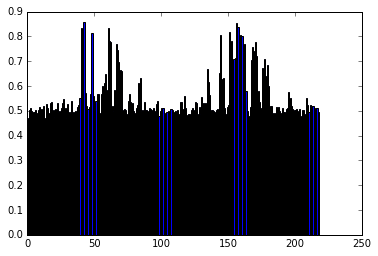

In [19]:
omission.mean_plot(chan_scores)

In [20]:
good_baga_chidxs = np.where(np.mean(chan_scores, axis=1)>.6)[0]
print good_baga_chidxs

[ 40  41  42  48  56  57  58  60  61  62  66  67  68  69  70  83  84 134
 135 143 144 145 146 151 152 154 155 156 157 158 159 160 161 162 167 168
 169 170 171 175 176 177 178 179 180]


In [21]:
good_baga_chans = [all_epochs.ch_names[i] for i in good_baga_chidxs]
print good_baga_chans

[u'EEG 57', u'EEG 58', u'EEG 59', u'EEG 65', u'EEG 73', u'EEG 74', u'EEG 75', u'EEG 77', u'EEG 78', u'EEG 79', u'EEG 84', u'EEG 85', u'EEG 86', u'EEG 87', u'EEG 88', u'EEG 105', u'EEG 106', u'EEG 166', u'EEG 167', u'EEG 175', u'EEG 176', u'EEG 177', u'EEG 178', u'EEG 184', u'EEG 187', u'EEG 189', u'EEG 190', u'EEG 191', u'EEG 192', u'EEG 193', u'EEG 194', u'EEG 195', u'EEG 196', u'EEG 197', u'EEG 202', u'EEG 203', u'EEG 204', u'EEG 205', u'EEG 206', u'EEG 211', u'EEG 212', u'EEG 213', u'EEG 214', u'EEG 215', u'EEG 216']


## Plot predictions accuracies on brain

In [22]:
# For EEG prefix
full_chan_nms = ['EEG %d'%chnum for chnum in range(1, 251)] ###### update this value according to subjectID
full_chan_scores = np.zeros(len(full_chan_nms))

In [23]:
inds = [i for i, x in enumerate(full_chan_nms) if x in good_baga_chans]
print inds
full_chan_scores[inds] = 1

[56, 57, 58, 64, 72, 73, 74, 76, 77, 78, 83, 84, 85, 86, 87, 104, 105, 165, 166, 174, 175, 176, 177, 183, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 201, 202, 203, 204, 205, 210, 211, 212, 213, 214, 215]


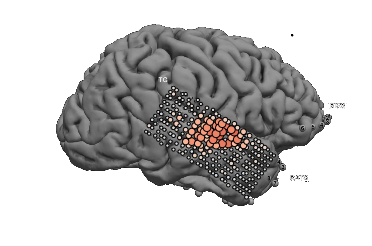

In [30]:
#Map to electrode positions
mapInd = [i for i, n in enumerate(full_chan_nms) if n in all_epochs.info['ch_names']]
#print mapInd
dataPlot = [0.5]*len(full_chan_nms) # if electrodes were excluded, set to 50% to avoid ugly large blue circles
len(dataPlot)
#len(DataM)
num = 0
for i in mapInd:
    #print i
    dataPlot[i]= np.mean(chan_baga_scores, axis=1)[num]
    num = num + 1
    #print dataPlot
    #print x

plot_activity_on_brain(x, y, np.asarray(dataPlot), im, vmin = 0, vmax = 1)

#with PdfPages(sub_name +'BaGaClassificationDissertation' + '.pdf') as pdf:
        #g = plt.gca()
 #       pdf.savefig()

## Analysis 2: Classify omitted sounds using electrodes with good heard ba/ga classification 

In [ ]:
# classify using cross-validation, 
# fit the model to all the data (so it's trained and returned)
# optionally also run 500 bootstrap iterations (shuffled labels) to get null dist
# bgmodel, scores_exp_baga, scores_shuff_baga = omission.build_classifier(all_epochs, event_ids,
bg_model, scores_bg, scores_shuff_bg = omission.build_classifier(all_epochs, event_ids,
                good_baga_chans, ['expected_ba', 'expected_ga'], model, n_cv=n_cv,
                    t_start=t0, t_stop=t1, shuffle=True, n_shuff_it=500, rescale = False)

## Data visualization: Where are the omission activations? 

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


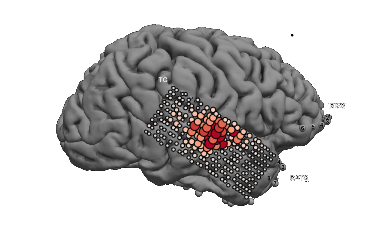

In [31]:
# HFB plotting on the brain - heard syllables

mode = 'zscore'
twin1 = 0.1
twin2 = 0.2
#extract indices for time window of interest
tstart = (twin1-all_epochs.tmin)*all_epochs.info['sfreq']
tstop = (twin2-all_epochs.tmin)*all_epochs.info['sfreq']


# make tstart and tstop integers
tstart = int(round(tstart))
tstop = int(round(tstop))

Data = all_epochs['ba'].get_data()[:,:,:]
#print Data
DataN = mne.baseline.rescale(Data, all_epochs.times, [-0.2, 0],  mode, copy = True)
DataM = np.mean(np.mean(DataN[:,:,tstart:tstop], 2),0)

# if you want to average two together: 
Data2 = all_epochs['ga'].get_data()[:,:,:]
#print Data
DataN2 = mne.baseline.rescale(Data, all_epochs.times, [-0.2, 0],  mode, copy = True)
DataM2 = np.mean(np.mean(DataN[:,:,tstart:tstop], 2),0)

DataM = (DataM+DataM2)/2

#print(DataM.shape)

#Map to electrode positions
mapInd = [i for i, n in enumerate(full_chan_nms) if n in all_epochs.info['ch_names']]
#print mapInd
dataPlot = [0]*len(full_chan_nms)
len(dataPlot)
len(DataM)
num = 0
for i in mapInd:
    #print i
    dataPlot[i]= DataM[num]
    num = num + 1
#print dataPlot
#print x

plot_activity_on_brain(x,y, np.asarray(dataPlot), im, vmin = -3, vmax = 3)

#with PdfPages(sub_name +'actBrainBaGa_100200_scaleis3' + '.pdf') as pdf:
#        #g = plt.gca()
#        pdf.savefig()


Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


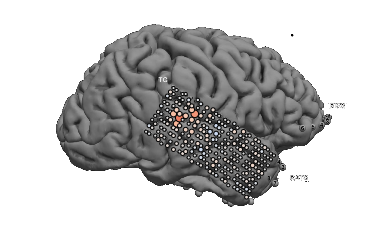

In [33]:
# HFB plotting on the brain - omissions

mode = 'zscore'
twin1 = 0.1
twin2 = 0.2
#extract indices for time window of interest
tstart = (twin1-all_epochs.tmin)*all_epochs.info['sfreq']
tstop = (twin2-all_epochs.tmin)*all_epochs.info['sfreq']


# make tstart and tstop integers
tstart = int(round(tstart))
tstop = int(round(tstop))

Data = all_epochs['expected_ba'].get_data()[:,:,:]
#print Data
DataN = mne.baseline.rescale(Data, all_epochs.times, [-0.2, 0],  mode, copy = True)
DataM = np.mean(np.mean(DataN[:,:,tstart:tstop], 2),0)

# if you want to average two together: 
Data2 = all_epochs['expected_ga'].get_data()[:,:,:]
#print Data
DataN2 = mne.baseline.rescale(Data, all_epochs.times, [-0.2, 0],  mode, copy = True)
DataM2 = np.mean(np.mean(DataN[:,:,tstart:tstop], 2),0)

DataM = (DataM+DataM2)/2

#print(DataM.shape)

#Map to electrode positions
mapInd = [i for i, n in enumerate(full_chan_nms) if n in all_epochs.info['ch_names']]
#print mapInd
dataPlot = [0]*len(full_chan_nms)
len(dataPlot)
len(DataM)
num = 0
for i in mapInd:
    #print i
    dataPlot[i]= DataM[num]
    num = num + 1
#print dataPlot
#print x

plot_activity_on_brain(x,y, np.asarray(dataPlot), im, vmin = -3, vmax = 3)

#with PdfPages(sub_name +'actBrainBaGa_100200_scaleis3' + '.pdf') as pdf:
#        #g = plt.gca()
#        pdf.savefig()


## Analysis 3: Classify omitted sounds using above baseline omission activations
#### Since the original decoding approach (analysis 2) does not seem to work, and the omission activations seem to be located in a specific part of STG, we now do a post-hoc analysis tot see if the omission activations specifically contain information on which syllable was omitted